# Proyecto End to End de Machine Learning 
### Viviendas en venta en Madrid


## 0. Librerías
 

In [1]:
# importación agrupada de librerías necesarias en este notebook
import pandas as pd
from pandas import StringDtype
import numpy as np
import json

import sys
import os

from scipy import stats
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, LabelBinarizer, MultiLabelBinarizer, OneHotEncoder 

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

#warnings.filterwarnings('ignore')

# Añado el directorio padre (del que está este notebook) a sys.path
sys.path.append(os.path.abspath('../'))
from scripts.utils_agv import ini_inspec, crear_tabla_resumen, categoricas, numericas

## 4. Compresión de variables

In [2]:
# carga de los datos guardados en el anterior paso
df = pd.read_csv('../data/processed/ide_viv_limpieza0_2025-03-11.csv', index_col='propertyCode')

In [3]:
df.index.name = 'ID'
# Mover la columna 'price' a la primera posición
columnas = ['price'] + [col for col in df.columns if col != 'price']
df = df.reindex(columns=columnas)
print (df.shape)
df.head(1)

(1747, 24)


,price,numPhotos,floor,propertyType,size,exterior,rooms,bathrooms,address,district,...,hasVideo,status,hasLift,priceByArea,detailedType,suggestedTexts,hasPlan,has3DTour,has360,topPlus
ID,,,,,,,,,,,,,,,,,,,,,
107526421,1095000.0,43,3,flat,146.0,True,3,2,calle de las Fuentes,Centro,...,True,good,True,7500.0,{'typology': 'flat'},"{'subtitle': 'Sol, Madrid', 'title': 'Piso en ...",True,True,False,True


In [4]:
ini_inspec(df)

=== TAMAÑO Y ESTRUCTURA DE LOS DATOS ===
Número total de registros (filas): 1747
Número de columnas: 24
Uso de memoria: 281.50 KB


=== TIPOS DE DATOS Y NOMBRES DE COLUMNAS ===
price             float64
numPhotos           int64
floor              object
propertyType       object
size              float64
exterior           object
rooms               int64
bathrooms           int64
address            object
district           object
neighborhood       object
latitude          float64
longitude         float64
description        object
hasVideo             bool
status             object
hasLift            object
priceByArea       float64
detailedType       object
suggestedTexts     object
hasPlan              bool
has3DTour            bool
has360               bool
topPlus              bool
dtype: object


Información detallada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 1747 entries, 107526421 to 107518858
Data columns (total 24 columns):
 #   Column          Non-Null C

Después de esta primera inspección, confirmado que no hay duplicados, vamos a abordar los problemas que observo: valores faltantes, contenidos como diccionario.

### Tratamiento (desdoblado) de las columnas cuyos valores son diccionarios

In [5]:
df['detailedType'].unique()

array(["{'typology': 'flat'}",
       "{'typology': 'flat', 'subTypology': 'studio'}",
       "{'typology': 'flat', 'subTypology': 'penthouse'}",
       "{'typology': 'flat', 'subTypology': 'duplex'}"], dtype=object)

In [6]:
df['suggestedTexts'].unique()

array(["{'subtitle': 'Sol, Madrid', 'title': 'Piso en calle de las Fuentes'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Piso en calle del Divino Pastor'}",
       "{'subtitle': 'Lavapiés-Embajadores, Madrid', 'title': 'Piso'}",
       "{'subtitle': 'Sol, Madrid', 'title': 'Piso en Carrera de San Jerónimo'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Estudio en calle de San Andrés'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Ático en calle de Fuencarral'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Piso en calle de Fuencarral'}",
       "{'subtitle': 'Palacio, Madrid', 'title': 'Dúplex en calle de Santiago'}",
       "{'subtitle': 'Chueca-Justicia, Madrid', 'title': 'Piso en calle de Apodaca'}",
       "{'subtitle': 'Sol, Madrid', 'title': 'Piso'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Piso en calle del Espíritu Santo'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 't

Voy a separar en columnas aquellas cuyos datos son dicionarios:


In [7]:
#FUNCIÓN PARA EXPANDIR CELDAS CON CONTENIDO DICCIONARIOS
def expand_dict_columns(df):
    """
    Expande las columnas del dataframe de Idealista que contienen diccionarios.
    
    Parámetros:
    df (pandas.DataFrame): DataFrame con datos de Idealista
    
    Retorna:
    pandas.DataFrame: DataFrame con las columnas expandidas
    """
    # Hacer una copia del dataframe original para no modificarlo
    df_processed = df.copy()
    
    def parse_dict_safely(value):
        """Convierte strings a diccionarios de forma segura sin usar ast"""
        if pd.isna(value):
            return {}
        if isinstance(value, dict):
            return value
        if isinstance(value, str) and value.strip():
            try:
                # Intentar convertir usando json.loads
                return json.loads(value)
            except json.JSONDecodeError:
                try:
                    # Si falla, corregimos comillas simples a dobles
                    value = value.replace("'", "\"")
                    return json.loads(value)
                except json.JSONDecodeError:
                    # Si aún falla, retornar vacío
                    return {}
        return {}
    
    def process_column(column_name, field_mappings):
        """
        Procesa una columna de diccionario y extrae campos específicos.
        
        Parámetros:
        column_name (str): Nombre de la columna a procesar
        field_mappings (dict): Diccionario donde la clave es el nombre del campo 
                               a extraer y el valor es un valor por defecto
        """
        if column_name not in df_processed.columns:
            return
            
        # Convertir strings a diccionarios
        df_processed[column_name] = df_processed[column_name].apply(parse_dict_safely)
        
        # Extraer cada campo del diccionario
        for field, default_value in field_mappings.items():
            new_column_name = f"{column_name}_{field}"
            df_processed[new_column_name] = df_processed[column_name].apply(
                lambda x: x.get(field, default_value) if isinstance(x, dict) else default_value
            )
    
    # Definir los campos a extraer para cada columna
    column_fields = {
        'suggestedTexts': {'subtitle': None, 'title': None},
        'detailedType': {'typology': None, 'subTypology': None},
        'parkingSpace': {
            'hasParkingSpace': False, 
            'isParkingSpaceIncludedInPrice': None,
            'parkingSpacePrice': None
        }
    }
    
    # Procesar cada columna
    for column, fields in column_fields.items():
        process_column(column, fields)
    
    # Eliminar las columnas originales
    columns_to_drop = [col for col in column_fields.keys() if col in df_processed.columns]
    df_processed = df_processed.drop(columns=columns_to_drop)
    
    return df_processed

In [8]:
# CELDA SALTADA intento de tratamiento de todas las columnas con diccionarios, incluso Parking
pass
def expand_dict_columns(df):
    """
    Expande las columnas del dataframe de Idealista que contienen diccionarios.
    
    Parámetros:
    df (pandas.DataFrame): DataFrame con datos de Idealista
    
    Retorna:
    pandas.DataFrame: DataFrame con las columnas expandidas
    """
    # Hacer una copia del dataframe original para no modificarlo
    df_processed = df.copy()
    
    def parse_dict_safely(value):
        """Convierte strings a diccionarios de forma segura sin usar ast"""
        if pd.isna(value):
            return {}
        if isinstance(value, dict):
            return value
        if isinstance(value, str) and value.strip():
            try:
                # Intentar convertir usando json.loads
                return json.loads(value)
            except json.JSONDecodeError:
                try:
                    # Si falla, corregimos comillas simples a dobles
                    value = value.replace("'", "\"")
                    return json.loads(value)
                except json.JSONDecodeError:
                    # Si aún falla, retornar vacío
                    return {}
        return {}
    
    # Procesar columna suggestedTexts
    if 'suggestedTexts' in df_processed.columns:
        df_processed['suggestedTexts'] = df_processed['suggestedTexts'].apply(parse_dict_safely)
        df_processed['suggestedTexts_subtitle'] = df_processed['suggestedTexts'].apply(
            lambda x: x.get('subtitle') if isinstance(x, dict) else None
        )
        df_processed['suggestedTexts_title'] = df_processed['suggestedTexts'].apply(
            lambda x: x.get('title') if isinstance(x, dict) else None
        )
    
    # Procesar columna detailedType
    if 'detailedType' in df_processed.columns:
        df_processed['detailedType'] = df_processed['detailedType'].apply(parse_dict_safely)
        df_processed['detailedType_typology'] = df_processed['detailedType'].apply(
            lambda x: x.get('typology') if isinstance(x, dict) else None
        )
        df_processed['detailedType_subTypology'] = df_processed['detailedType'].apply(
            lambda x: x.get('subTypology') if isinstance(x, dict) else None
        )
    
    # Procesar columna parkingSpace - Esto lo dejamos explícito para manejar mejor los casos especiales
    if 'parkingSpace' in df_processed.columns:
        # Convertir strings a diccionarios y manejar valores NaN
        df_processed['parkingSpace'] = df_processed['parkingSpace'].apply(parse_dict_safely)
        
        # Extraer hasParkingSpace - valor por defecto es False
        df_processed['parkingSpace_hasParkingSpace'] = df_processed['parkingSpace'].apply(
            lambda x: x.get('hasParkingSpace', False) if isinstance(x, dict) else False
        )
        
        # Extraer isParkingSpaceIncludedInPrice - Sin valor por defecto para preservar NaN cuando no existe
        df_processed['parkingSpace_isParkingSpaceIncludedInPrice'] = df_processed['parkingSpace'].apply(
            lambda x: x.get('isParkingSpaceIncludedInPrice') if isinstance(x, dict) else pd.NA
        )
        
        # Extraer parkingSpacePrice - Convertimos a float explícitamente si existe
        df_processed['parkingSpace_parkingSpacePrice'] = df_processed['parkingSpace'].apply(
            lambda x: float(x.get('parkingSpacePrice')) if isinstance(x, dict) and 'parkingSpacePrice' in x and x['parkingSpacePrice'] is not None else pd.NA
        )
    
    # Eliminar las columnas originales que contenían diccionarios
    columns_to_drop = []
    for col in ['suggestedTexts', 'detailedType', 'parkingSpace']:
        if col in df_processed.columns:
            columns_to_drop.append(col)
    
    df_processed = df_processed.drop(columns=columns_to_drop)
    return df_processed

In [9]:
# df_ampliado_dict = expand_dict_columns(df, dict_columns=['otraColumnaDict', 'segundaColumnaDict'])
df_ampliado_dict = expand_dict_columns(df)
df_ampliado_dict

,price,numPhotos,floor,propertyType,size,exterior,rooms,bathrooms,address,district,...,hasLift,priceByArea,hasPlan,has3DTour,has360,topPlus,suggestedTexts_subtitle,suggestedTexts_title,detailedType_typology,detailedType_subTypology
ID,,,,,,,,,,,,,,,,,,,,,
107526421,1095000.0,43,3,flat,146.0,True,3,2,calle de las Fuentes,Centro,...,True,7500.0,True,True,False,True,"Sol, Madrid",Piso en calle de las Fuentes,flat,None
107246640,1195000.0,27,2,flat,134.0,True,3,3,calle del Divino Pastor,Centro,...,True,8918.0,True,True,True,True,"Malasaña-Universidad, Madrid",Piso en calle del Divino Pastor,flat,None
106773918,790000.0,33,3,flat,148.0,True,2,2,Barrio Lavapiés-Embajadores,Centro,...,True,5338.0,True,True,False,True,"Lavapiés-Embajadores, Madrid",Piso,flat,None
102711209,2350000.0,44,5,flat,218.0,True,4,4,Carrera de San Jerónimo,Centro,...,True,10780.0,True,True,False,True,"Sol, Madrid",Piso en Carrera de San Jerónimo,flat,None
106822977,235000.0,34,bj,studio,38.0,False,0,1,calle de San Andrés,Centro,...,True,6184.0,True,True,False,True,"Malasaña-Universidad, Madrid",Estudio en calle de San Andrés,flat,studio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107419060,4200000.0,0,3,flat,288.0,True,3,3,calle del Almirante,Centro,...,True,14583.0,False,False,False,False,"Chueca-Justicia, Madrid",Piso en calle del Almirante,flat,None
106976644,2810000.0,0,1,flat,238.0,True,3,4,Barrio Sol,Centro,...,True,11807.0,False,False,False,False,"Sol, Madrid",Piso,flat,None
107230033,2170000.0,0,4,penthouse,125.0,True,2,3,Barrio Chueca-Justicia,Centro,...,True,17360.0,False,False,False,False,"Chueca-Justicia, Madrid",Ático,flat,penthouse


In [10]:
# conversión Parking Space en multiples columnas bien: finalmente esto no lo he realizado, aunque hice multiples intentos, y nunca lograba que me funcionara bien
# TODO mejorar esto
# df_ampliado_dict['parkingSpace_hasParkingSpace'].unique()
# df_ampliado_dict['parkingSpace_isParkingSpaceIncludedInPrice'].unique()
# df_ampliado_dict['parkingSpace_parkingSpacePrice'].unique()

In [11]:
df2=df_ampliado_dict.copy()

In [12]:
df2['detailedType_typology'].unique()

array(['flat'], dtype=object)

In [13]:
df2['detailedType_subTypology'].unique()

array([None, 'studio', 'penthouse', 'duplex'], dtype=object)

In [14]:
ini_inspec(df2)

=== TAMAÑO Y ESTRUCTURA DE LOS DATOS ===
Número total de registros (filas): 1747
Número de columnas: 26
Uso de memoria: 308.80 KB


=== TIPOS DE DATOS Y NOMBRES DE COLUMNAS ===
price                       float64
numPhotos                     int64
floor                        object
propertyType                 object
size                        float64
exterior                     object
rooms                         int64
bathrooms                     int64
address                      object
district                     object
neighborhood                 object
latitude                    float64
longitude                   float64
description                  object
hasVideo                       bool
status                       object
hasLift                      object
priceByArea                 float64
hasPlan                        bool
has3DTour                      bool
has360                         bool
topPlus                        bool
suggestedTexts_subtitle      ob

In [15]:
crear_tabla_resumen(df2)

,Tipo de dato,Categoría,Cardinalidad,% Cardinalidad,Valores faltantes,% Valores faltantes
Columna,,,,,,
price,float64,Numérica Continua,505,28.906697,0,0.000000
numPhotos,int64,Numérica Discreta,81,4.636520,0,0.000000
floor,object,Categórica Nominal,16,0.915856,64,3.663423
propertyType,object,Categórica Nominal,4,0.228964,0,0.000000
size,float64,Numérica Continua,261,14.939897,0,0.000000
exterior,object,Binaria,2,0.114482,24,1.373784
rooms,int64,Numérica Discreta,12,0.686892,0,0.000000
bathrooms,int64,Numérica Discreta,10,0.572410,0,0.000000
address,object,Categórica Nominal,524,29.994276,0,0.000000


In [16]:
categoricas(df2)

,count,unique,top,freq,missing,missing_percent
columna,,,,,,
floor,1683,16,1,409,64,3.663423
propertyType,1747,4,flat,1485,0,0.000000
exterior,1723,2,True,1315,24,1.373784
address,1747,524,Barrio Chueca-Justicia,107,0,0.000000
district,1747,1,Centro,1747,0,0.000000
neighborhood,1747,6,Malasaña-Universidad,415,0,0.000000
description,1747,1698,¡No pierdas la oportunidad de vivir en el cora...,11,0,0.000000
status,1742,3,good,1497,5,0.286205
hasLift,1741,2,True,1223,6,0.343446


### Análisis de las variables

A continuación, una rápida analítica de cada una de las variables.
1. **Variable**: nombre variable/alias
2. **Data type**: cualitativa, cuantitativa, ordinal, continua...¿?
3. **Segmento**: clasificar las variables según su significado. Si son variables demográficas, económicas, identificadores, tiempo...
4. **Expectativas**: un pequeño indicador personal de si resultará útil la variable. ¿Necesito esta variable para la solución? ¿Cómo de importante será esta variable? ¿Esta info la recoge otra variable ya vista?
5. **Conclusiones**: después del análisis anterior, llegar a unas conclusiones sobre la importancia de la variable.

|Variable |Dtype |tipo |faltantes |segmento |expectativas |conclusiones|
|--|--|--|--|--|--|--|
|||||unidades |descripción |
|propertyCode(ID)| int64| entero|código numérico Idealista||ID
|numPhotos|int64 | entero||ud.|posible categorizador|probar| 
|floor |object | float(discreto)| 64|piso|valiosa|importante|
|price | float64| continuo||€|predicción|target|
|propertyType| object |categórico|
|size| float64| continuo|
|exterior| object| booleano |24|bool|valioso|importante|
|rooms| int64| entero|||||
|bathrooms| int64| entero|
|address| object| categórico|
|district| object| categórico|
|neighborhood| object| categórico|
|latitude|float64 | continuo|
|longitude|float64 | continuo|
|description| object| categórico|
|hasVideo| bool| booleano |
|status| object| categórico|5|valoración incremental discreta|valiosa|ordinal encoder|
|hasLift|  object| booleano |6| bool|valiosa|importante|
|priceByArea| float64 | continuo|
|hasPlan| bool| booleano |
|has3DTour|bool| booleano |
|has360| bool| booleano |
|topPlus| bool| booleano |
|suggestedTexts_subtitle|object| categórico| | ¿datos adicionales?|¿redundante?||
|suggestedTexts_title |object| categórico| | ¿datos adicionales?|¿redundante?||
|detailedType_typology |   object| categórico| | clasificación|¿redundante?|eliminar|
|detailedType_subTypology | object| categórico|1524| clasificación|¿redundante?|eliminar|

## 5. Reducción (tratamiento) de variables preliminar

En este caso que estamos trabajando solo con el distrito centro, puedo eliminara la columna 'district'. En caso de trabajar con varios distritos la mantendría para introducirla en el módelo.

In [17]:
df2.drop('district', axis=1, inplace=True)

### Tratamiento de la columna 'floor'

In [18]:
df2['floor'].unique()

array(['3', '2', '5', 'bj', '4', '6', '10', '1', '8', 'en', nan, '11',
       'st', '9', 'ss', '-1', '7'], dtype=object)

In [19]:
print(f"Número de valores faltantes en 'floor': {df2['floor'].isnull().sum()}")
print("Filas con valores faltantes en 'floor':")
df2[df2['floor'].isnull()].head().T


Número de valores faltantes en 'floor': 64
Filas con valores faltantes en 'floor':


ID,105028115,106588391,106970345,107150334,107123975
price,1300000.0,780000.0,1500000.0,1175000.0,900000.0
numPhotos,33,49,6,43,17
floor,NaN,NaN,NaN,NaN,NaN
propertyType,flat,flat,flat,flat,flat
size,230.0,125.0,150.0,169.0,94.0
exterior,True,True,True,True,True
rooms,3,2,2,3,3
bathrooms,2,2,3,2,2
address,Barrio Lavapiés-Embajadores,plaza de la Cruz Verde,calle del Molino de Viento,calle de San Bernardo,calle de los Reyes
neighborhood,Lavapiés-Embajadores,Palacio,Malasaña-Universidad,Malasaña-Universidad,Malasaña-Universidad


In [20]:
# Ajustar pandas para que no trunque el texto
pd.set_option('display.max_colwidth', None)

# Filtrar el DataFrame para obtener las filas donde 'floor' tiene valores NaN
df2[df2['floor'].isnull()][['floor','description']]

,floor,description
ID,,
105028115,NaN,"Distinguida vivienda en Madrid histórico Engel & Völkers presenta esta distinguida propiedad en una tranquila calle junto a la Plaza Mayor de 230 metros cuadrados, incluyendo los elementos comunes, según catastro. La propiedad destaca por su distribución y reforma, que combina con gran estilo elementos actuales con los propios de principios del siglo XX. Se encuentra lista para entrar a vivir. Se distribuye en una representativa entrada y una amplia social donde encontramos un gran salón comedor con tres balcones a la calle. La cocina, práctica y funcional, se encuentra equipada con electrodomésticos de alta gama, y zona de lavandería independiente. La zona de noche se compone de tres dormitorios, uno de ellos con vestidor y cuarto baño incorporado. Los otros dos dormitorios, también dobles, comparten el otro cuarto de baño completo. Dispone de aire acondicionado por conductos y sistema de calefacción individual. La vivienda ofrece luz natural en todas sus estancias y un gran encanto a través de su distribución ideal entre la zona social y la zona más privada. Este inmueble se encuentra en la primera planta de una finca señorial y tradicional propia de la zona de 1905, completamente restaurada, y con conserje de lunes a viernes. La finca cuenta con ascensor y elementos arquitectónicos decorativos originales en las zonas comunes. Por su cercanía al Ministerio de Asuntos Exteriores goza de gran seguridad y vigilancia en el exterior. Si se necesita se puede adquirir plaza de garaje en la finca contigua. Se trata de una propiedad exclusiva en un edificio clásico histórico en el corazón de Madrid. Por sus dimensiones y ubicación, la vivienda es apta tanto para aquéllos que quieran distinarla al alquiler de alto standing, como para los que decidan instalarse con su familia en una vivienda singular en pleno centro de Madrid. La vivienda se encuentra en una calle en pleno corazón del Madrid histórico, monumental y cultural, junto a la Puerta del Sol. La zona dispone de la más variada oferta de pequeños comercios tradicionales y cosmopolitas de Madrid. Al salir de casa, y sin necesidad de utilizar el transporte público o privado, encontramos toda la riqueza gastronómica representada por sus mejores restaurantes y bares tradicionales, así como toda la oferta cultural de la ciudad. Su proximidad a la Plaza Mayor y Puerta del Sol nos permite en un agradable paseo llegar a la zona comercial más importante del país."
106588391,NaN,"Bienvenido a este encantador apartamento en Palacio, Centro, Madrid. Con 125 m², esta propiedad ofrece un espacio generoso y bien distribuido. Cuenta con 2 dormitorios y 2 baños, ideal para una familia o para compartir. El apartamento se encuentra en buen estado y forma parte de un edificio clásico que cuenta con ascensor, combinando el encanto tradicional con la comodidad moderna. Disfrute de los días soleados en su balcón privado y manténgase cómodo durante todo el año, gracias al aire acondicionado en verano y la calefacción eléctrica o de gas en invierno. Este apartamento es una oportunidad única para vivir en pleno centro de Madrid, rodeado de historia, cultura y todos los servicios que la ciudad ofrece. Palacio es un barrio histórico y emblemático situado en el distrito Centro de Madrid. Hogar de monumentos icónicos como el Palacio Real, la Catedral de la Almudena y la Plaza de Oriente, combina historia, cultura y un ambiente único. Sus calles adoquinadas, como las de la Plaza de la Villa o el Viaducto de Segovia, ofrecen un viaje al pasado, mientras que su oferta de restaurantes, teatros y tiendas modernas garantiza una experiencia vibrante. Con excelentes conexiones de transporte público y cercanía a zonas como La Latina y Ópera, Palacio es ideal para quienes buscan vivir en un entorno cultural privilegiado en el corazón de Madrid. Perfecto para quienes buscan comodidad, estilo y una ubicación inmejorable. ¡No dejes pasar la oportunidad de convertir este espacio en t

In [21]:
# Crear una lista con los IDs donde 'floor' es NaN
ids_floor_nan = df2[df2['floor'].isnull()].index.tolist()

# Guardar la lista de IDs en una variable para uso futuro
print(f"Lista de IDs con 'floor' como NaN (longitud {len(ids_floor_nan)}):")
print(ids_floor_nan)

Lista de IDs con 'floor' como NaN (longitud 64):
[105028115, 106588391, 106970345, 107150334, 107123975, 106454290, 106054285, 107061744, 105195927, 107166132, 104426468, 107456942, 106803725, 105976092, 107154378, 107559162, 105976144, 107154335, 107287333, 104586987, 106994186, 105356182, 96808581, 104305083, 107317184, 107318280, 107318147, 107317491, 107317747, 107318011, 107317459, 107317115, 107317630, 107207979, 105407331, 107533869, 107323127, 107153590, 107327391, 107320797, 107157962, 106186508, 106186917, 107356892, 104955056, 104955037, 104685614, 99979572, 106791711, 107394604, 103312737, 106205832, 104955058, 107205252, 105250106, 105052319, 104814531, 104361806, 105024469, 105745692, 106656561, 106657042, 105698822, 105635470]


Esta función de imputación se basa en busca piso en la descripción, asumiendo que en el distrito centro no existen muchos bloques de más de 5 alturas, y es esos casos excepcionales, es seguro que hubieran indicado explícitamente el piso en su campo.

In [22]:
def imputar_floor(dataframe):
    """
    Imputa valores en la columna 'floor' basándose en palabras clave encontradas en la columna 'description'
    para las filas donde 'floor' es NaN.

    :param dataframe: DataFrame que debe contener las columnas 'floor' y 'description'.
    :return: DataFrame con los valores imputados en 'floor'.
    """
    # Diccionario que mapea palabras clave a valores de 'floor'
    floor_mapping = {
        1: ['1º', '1ª', 'primer piso', 'piso primero', 'planta primera', 'primera planta'],
        2: ['2º', '2ª', 'segundo piso', 'piso segundo', 'planta segunda', 'segunda planta'],
        3: ['3º', '3ª', 'tercer piso', 'piso tercero', 'tercera planta'],
        4: ['4º', '4ª', 'cuarto piso', 'cuarta planta'],
        5: ['5º', '5ª', 'quinto piso', 'quinta planta'],
        6: ['6º', '6ª','sexto piso', 'sexta planta']
    }

    # Filtrar las filas donde 'floor' es NaN
    filtro = dataframe[dataframe['floor'].isnull()]

    # Iterar sobre el filtro para verificar palabras clave
    for index, row in filtro.iterrows():
        descripcion = str(row['description']).lower()  # Convertir a minúsculas
        for floor, keywords in floor_mapping.items():
            # Verificar si alguna palabra clave está en la descripción
            if any(keyword in descripcion for keyword in keywords):
                dataframe.at[index, 'floor'] = floor  # Asignar el valor correspondiente
                break  # Romper el bucle después de encontrar una coincidencia

    return dataframe

In [23]:
imputar_floor(df2)

,price,numPhotos,floor,propertyType,size,exterior,rooms,bathrooms,address,neighborhood,...,hasLift,priceByArea,hasPlan,has3DTour,has360,topPlus,suggestedTexts_subtitle,suggestedTexts_title,detailedType_typology,detailedType_subTypology
ID,,,,,,,,,,,,,,,,,,,,,
107526421,1095000.0,43,3,flat,146.0,True,3,2,calle de las Fuentes,Sol,...,True,7500.0,True,True,False,True,"Sol, Madrid",Piso en calle de las Fuentes,flat,None
107246640,1195000.0,27,2,flat,134.0,True,3,3,calle del Divino Pastor,Malasaña-Universidad,...,True,8918.0,True,True,True,True,"Malasaña-Universidad, Madrid",Piso en calle del Divino Pastor,flat,None
106773918,790000.0,33,3,flat,148.0,True,2,2,Barrio Lavapiés-Embajadores,Lavapiés-Embajadores,...,True,5338.0,True,True,False,True,"Lavapiés-Embajadores, Madrid",Piso,flat,None
102711209,2350000.0,44,5,flat,218.0,True,4,4,Carrera de San Jerónimo,Sol,...,True,10780.0,True,True,False,True,"Sol, Madrid",Piso en Carrera de San Jerónimo,flat,None
106822977,235000.0,34,bj,studio,38.0,False,0,1,calle de San Andrés,Malasaña-Universidad,...,True,6184.0,True,True,False,True,"Malasaña-Universidad, Madrid",Estudio en calle de San Andrés,flat,studio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107419060,4200000.0,0,3,flat,288.0,True,3,3,calle del Almirante,Chueca-Justicia,...,True,14583.0,False,False,False,False,"Chueca-Justicia, Madrid",Piso en calle del Almirante,flat,None
106976644,2810000.0,0,1,flat,238.0,True,3,4,Barrio Sol,Sol,...,True,11807.0,False,False,False,False,"Sol, Madrid",Piso,flat,None
107230033,2170000.0,0,4,penthouse,125.0,True,2,3,Barrio Chueca-Justicia,Chueca-Justicia,...,True,17360.0,False,False,False,False,"Chueca-Justicia, Madrid",Ático,flat,penthouse


In [24]:
df2['floor'].isnull().sum()

np.int64(53)

In [25]:
df2['floor'].unique()

array(['3', '2', '5', 'bj', '4', '6', '10', '1', '8', 'en', 1, '11', nan,
       'st', '9', 6, 'ss', '-1', 2, '7'], dtype=object)

In [26]:
# Mostrar el resultado de la lista de las filas imputadas
df2.loc[ids_floor_nan, ['floor','description']]

,floor,description
ID,,
105028115,1,"Distinguida vivienda en Madrid histórico Engel & Völkers presenta esta distinguida propiedad en una tranquila calle junto a la Plaza Mayor de 230 metros cuadrados, incluyendo los elementos comunes, según catastro. La propiedad destaca por su distribución y reforma, que combina con gran estilo elementos actuales con los propios de principios del siglo XX. Se encuentra lista para entrar a vivir. Se distribuye en una representativa entrada y una amplia social donde encontramos un gran salón comedor con tres balcones a la calle. La cocina, práctica y funcional, se encuentra equipada con electrodomésticos de alta gama, y zona de lavandería independiente. La zona de noche se compone de tres dormitorios, uno de ellos con vestidor y cuarto baño incorporado. Los otros dos dormitorios, también dobles, comparten el otro cuarto de baño completo. Dispone de aire acondicionado por conductos y sistema de calefacción individual. La vivienda ofrece luz natural en todas sus estancias y un gran encanto a través de su distribución ideal entre la zona social y la zona más privada. Este inmueble se encuentra en la primera planta de una finca señorial y tradicional propia de la zona de 1905, completamente restaurada, y con conserje de lunes a viernes. La finca cuenta con ascensor y elementos arquitectónicos decorativos originales en las zonas comunes. Por su cercanía al Ministerio de Asuntos Exteriores goza de gran seguridad y vigilancia en el exterior. Si se necesita se puede adquirir plaza de garaje en la finca contigua. Se trata de una propiedad exclusiva en un edificio clásico histórico en el corazón de Madrid. Por sus dimensiones y ubicación, la vivienda es apta tanto para aquéllos que quieran distinarla al alquiler de alto standing, como para los que decidan instalarse con su familia en una vivienda singular en pleno centro de Madrid. La vivienda se encuentra en una calle en pleno corazón del Madrid histórico, monumental y cultural, junto a la Puerta del Sol. La zona dispone de la más variada oferta de pequeños comercios tradicionales y cosmopolitas de Madrid. Al salir de casa, y sin necesidad de utilizar el transporte público o privado, encontramos toda la riqueza gastronómica representada por sus mejores restaurantes y bares tradicionales, así como toda la oferta cultural de la ciudad. Su proximidad a la Plaza Mayor y Puerta del Sol nos permite en un agradable paseo llegar a la zona comercial más importante del país."
106588391,NaN,"Bienvenido a este encantador apartamento en Palacio, Centro, Madrid. Con 125 m², esta propiedad ofrece un espacio generoso y bien distribuido. Cuenta con 2 dormitorios y 2 baños, ideal para una familia o para compartir. El apartamento se encuentra en buen estado y forma parte de un edificio clásico que cuenta con ascensor, combinando el encanto tradicional con la comodidad moderna. Disfrute de los días soleados en su balcón privado y manténgase cómodo durante todo el año, gracias al aire acondicionado en verano y la calefacción eléctrica o de gas en invierno. Este apartamento es una oportunidad única para vivir en pleno centro de Madrid, rodeado de historia, cultura y todos los servicios que la ciudad ofrece. Palacio es un barrio histórico y emblemático situado en el distrito Centro de Madrid. Hogar de monumentos icónicos como el Palacio Real, la Catedral de la Almudena y la Plaza de Oriente, combina historia, cultura y un ambiente único. Sus calles adoquinadas, como las de la Plaza de la Villa o el Viaducto de Segovia, ofrecen un viaje al pasado, mientras que su oferta de restaurantes, teatros y tiendas modernas garantiza una experiencia vibrante. Con excelentes conexiones de transporte público y cercanía a zonas como La Latina y Ópera, Palacio es ideal para quienes buscan vivir en un entorno cultural privilegiado en el corazón de Madrid. Perfecto para quienes buscan comodidad, estilo y una ubicación inmejorable. ¡No dejes pasar la oportunidad de convertir este espacio en tu 

In [27]:
# Imputar el resto de NaNs restante a 0
df2['floor'] = df2['floor'].fillna(0)

### Tratamiento de la columna 'exterior'

In [28]:
df2['exterior'].unique()

array([True, False, nan], dtype=object)

In [29]:
pd.set_option('display.max_colwidth', None)
# Filtrar el DataFrame para obtener las filas donde 'exterior' tiene valores NaN
df2[df2['exterior'].isnull()][['exterior','description']]

,exterior,description
ID,,
107160108,NaN,"Exclusivo Piso con Vistas Únicas en el Corazón del Barrio de las Letras Descubre este luminoso y tranquilo piso, situado en la quinta planta de un edificio con ascensor, en pleno centro de Madrid. Una vivienda que destaca por sus espectaculares vistas despejadas y su ubicación privilegiada, en una de las zonas más deseadas de la ciudad. Diseño Práctico con Grandes Posibilidades * Salón amplio y diáfano, perfecto para crear diferentes entornos acogedores. * Cocina independiente, con la opción de integrarla al salón para un diseño más actual. * Dormitorio principal, espacioso y lleno de luz natural. * Baño funcional, cómodo y bien equipado. Aunque es abuhardillado, los techos altos y las vigas de madera vistas le aportan un encanto único, combinando carácter y amplitud. Además, esta vivienda ofrece múltiples posibilidades para personalizarla según tus gustos y necesidades. Una Finca Rehabilitada. El inmueble forma parte de una finca completamente rehabilitada, que ha sido cuidadosamente renovada para conservar su carácter especial. Entre sus mejoras destacan: * Dos ascensores nuevos para mayor comodidad. * Fachadas y zonas comunes recientemente pintadas y restauradas, que realzan la estética del edificio. Ubicación Privilegiada Enclavado en una tranquila calle del emblemático Barrio de las Letras, este piso te sitúa cerca de los lugares más icónicos de Madrid: * A escasos minutos del Paseo del Prado, el Jardín Botánico y museos como el Prado, el Thyssen y el Reina Sofía. * Próximo al animado Mercado de Antón Martín, ideal para disfrutar de la gastronomía local y productos frescos. * Excelentes conexiones de transporte, con estaciones de metro como Antón Martín y de tren como Atocha, que garantizan un acceso cómodo a cualquier punto de la ciudad. Vivir en el Barrio de las Letras El Barrio de las Letras combina historia, arte y cultura con una amplia oferta gastronómica y comercial. Sus calles peatonales y su ambiente único lo convierten en un lugar ideal tanto para vivir como para invertir. Estamos a tu disposición. No cobramos honorarios al comprador y ayudamos con la financiación. Contacta con nosotros los 7 días de la semana para obtener más información o concertar una visita. ¡No dejes escapar esta oportunidad única en el corazón de Madrid!"
107203148,NaN,"¿Te imaginas disfrutando de tu hogar en propiedad en una excelente ubicación en el centro de Madrid? ¡Testa Homes lo hace realidad! *La vivienda y fotos publicadas corresponden a una vivienda tipo, para más información consulte a su gestor comercial. Estupenda vivienda con maravilloso salón, cocina equipada con electrodomésticos de máxima calidad y diseño vanguardista, con una isla equipada con vitrocerámica, 4 dormitorios con armarios empotrados y 2 baños completamente equipado. Todas las estancias disponen de excelente iluminación gracias a sus amplios ventanales. El edificio cuenta con placas de energía solar y parking de bicis en sus zonas comunes; además dispone de garaje (opcional) por 50.000€ más. El inmueble está muy bien ubicado en el centro de Madrid, a pocos minutos del acceso al Paseo del Prado; la vivienda se encuentra a pocos minutos del parque de El Retiro, así como de multitud de opciones de restauración, colegios, institutos, hospitales, etc. Además, dispone de fácil acceso a transporte público gracias a su cercanía a la estación cercanías de Sol y el metro de Antón Martín (L1) y Sevilla (L2) al igual que varias líneas de autobuses a sus alrededores. En Testa Homes, te acompañamos durante todo el proceso de compra de la vivienda y te contamos todo con la mayor transparencia. Además, te ponemos en contacto con un asesor financiero que te informará de las mejores condiciones disponibles. *En relación a los suministros de luz y agua, será necesario que el nuevo comprador realice el cambio de titularidad a su nombre."
107450682,NaN,"PISO OCUPADO POR PERSONA SIN JUSTO TÍTULOESTE INMUEBLE DEBIDO A SU ESTADO OCUPACIONAL NO

In [30]:
# Crear una lista con los IDs donde 'exterior' es NaN
ids_exterior_nan = df2[df2['exterior'].isnull()].index.tolist()

# Guardar la lista de IDs en una variable para uso futuro
print(f"Lista de IDs con 'exterior' como NaN (longitud {len(ids_exterior_nan)}):")
print(ids_exterior_nan)

Lista de IDs con 'exterior' como NaN (longitud 24):
[107160108, 107203148, 107450682, 107369701, 107531019, 107202989, 107327391, 104902745, 107306175, 107356892, 104450806, 99979572, 106947006, 107280389, 106205832, 105052319, 104361806, 105024469, 105745692, 106656561, 106657042, 105698822, 105635470, 103106244]


In [31]:
def imputar_exterior(dataframe):
    """
    Esta función recorre un DataFrame y realiza imputaciones en la columna 'exterior' basándose
    en las expresiones encontradas en la columna 'description'.
    
    - Si la descripción contiene expresiones positivas, reemplaza NaN en 'exterior' por True.
    - Si la descripción contiene expresiones negativas, reemplaza NaN en 'exterior' por False.
    - Si no se encuentra ninguna coincidencia, también reemplaza NaN por False.
    
    :param dataframe: DataFrame que debe contener las columnas 'exterior' y 'description'.
    :return: DataFrame con los valores imputados en 'exterior'.
    """
    # Listas de expresiones a buscar
    expresiones_positivas = ['es exterior', 'exterior', 'piso exterior']
    expresiones_negativas = ['interior', 'es interior', 'no es exterior']

    # Filtrar las filas donde 'exterior' es NaN
    filtro = dataframe[dataframe['exterior'].isnull()]

    # Iterar sobre el filtro para verificar y reemplazar en el DataFrame original
    for index, row in filtro.iterrows():
        descripcion = str(row['description']).lower()
        if any(neg in descripcion for neg in expresiones_negativas):
            # Si hay una expresión negativa, reemplazar NaN por False
            dataframe.at[index, 'exterior'] = False
        elif any(pos in descripcion for pos in expresiones_positivas):
            # Si hay una expresión positiva, reemplazar NaN por True
            dataframe.at[index, 'exterior'] = True
        else:
            # Si no hay coincidencias, reemplazar NaN por False
            dataframe.at[index, 'exterior'] = False

    return dataframe


In [32]:
imputar_exterior (df2)

,price,numPhotos,floor,propertyType,size,exterior,rooms,bathrooms,address,neighborhood,...,hasLift,priceByArea,hasPlan,has3DTour,has360,topPlus,suggestedTexts_subtitle,suggestedTexts_title,detailedType_typology,detailedType_subTypology
ID,,,,,,,,,,,,,,,,,,,,,
107526421,1095000.0,43,3,flat,146.0,True,3,2,calle de las Fuentes,Sol,...,True,7500.0,True,True,False,True,"Sol, Madrid",Piso en calle de las Fuentes,flat,None
107246640,1195000.0,27,2,flat,134.0,True,3,3,calle del Divino Pastor,Malasaña-Universidad,...,True,8918.0,True,True,True,True,"Malasaña-Universidad, Madrid",Piso en calle del Divino Pastor,flat,None
106773918,790000.0,33,3,flat,148.0,True,2,2,Barrio Lavapiés-Embajadores,Lavapiés-Embajadores,...,True,5338.0,True,True,False,True,"Lavapiés-Embajadores, Madrid",Piso,flat,None
102711209,2350000.0,44,5,flat,218.0,True,4,4,Carrera de San Jerónimo,Sol,...,True,10780.0,True,True,False,True,"Sol, Madrid",Piso en Carrera de San Jerónimo,flat,None
106822977,235000.0,34,bj,studio,38.0,False,0,1,calle de San Andrés,Malasaña-Universidad,...,True,6184.0,True,True,False,True,"Malasaña-Universidad, Madrid",Estudio en calle de San Andrés,flat,studio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107419060,4200000.0,0,3,flat,288.0,True,3,3,calle del Almirante,Chueca-Justicia,...,True,14583.0,False,False,False,False,"Chueca-Justicia, Madrid",Piso en calle del Almirante,flat,None
106976644,2810000.0,0,1,flat,238.0,True,3,4,Barrio Sol,Sol,...,True,11807.0,False,False,False,False,"Sol, Madrid",Piso,flat,None
107230033,2170000.0,0,4,penthouse,125.0,True,2,3,Barrio Chueca-Justicia,Chueca-Justicia,...,True,17360.0,False,False,False,False,"Chueca-Justicia, Madrid",Ático,flat,penthouse


In [33]:
# Mostrar la lista de las filas imputadas
df2.loc[ids_exterior_nan, ['exterior']]

,exterior
ID,
107160108,False
107203148,False
107450682,False
107369701,False
107531019,False
107202989,False
107327391,False
104902745,False
107306175,False


In [34]:
df2['exterior'].unique()

array([True, False], dtype=object)

### Tratamiento de la columna 'status'

In [35]:
df2['status'].unique()

array(['good', 'renew', 'newdevelopment', nan], dtype=object)

In [36]:
# Crear una lista con los IDs donde 'status' es NaN
ids_status_nan = df2[df2['status'].isnull()].index.tolist()

# Guardar la lista de IDs en una variable para uso futuro
print(f"Lista de IDs con 'status' como NaN (longitud {len(ids_status_nan)}):")
print(ids_status_nan)

Lista de IDs con 'status' como NaN (longitud 5):
[107470368, 107447562, 106290271, 106634936, 107085111]


In [37]:
pd.set_option('display.max_colwidth', None)
# Filtrar el DataFrame para obtener las filas donde 'exterior' tiene valores NaN
df2[df2['status'].isnull()][['status','description']]

,status,description
ID,,
107470368,NaN,"Be Grand Las Letras es un conjunto residencial diseñado para experimentar lujo, modernidad e historia. Se trata de un proyecto de obra nueva, moderno y vanguardista en armonía con su entorno, situado en la calle Fúcar 5. Cuenta con 47 viviendas, 80 plazas de aparcamiento e increíbles áreas comunes como rooftop con piscina, gimnasio y jardín."
107447562,NaN,"En un enclave inmejorable, Junto a la Villa de París, se encuentra “Campoamor 4”, la única promoción de obra nueva en Las Salesas, la mejor zona del barrio de Justicia. Un edificio clásico totalmente rehabilitado con las comodidades más contemporáneas abre sus puertas desde el cual disfrutar la experiencia de vivir en la zona más vibrante de la capital europea más en boga. Las 8 exclusivas viviendas de Campoamor 4 ofrecen un estilo inconfundible, con las comodidades de un edificio de época totalmente reformado, estas viviendas de dos y tres dormitorios han sido diseñadas para aquellos que quieren vivir el Madrid más vibrante y cosmopolita sin renunciar al encanto de lo clásico, interiorismo a cargo del estudio de Tristán Domeq. Con una demanda creciente y una oferta limitada, Justicia se encuentra en el inicio de un rally alcista que se presenta como la nueva oportunidad para adquirir inmuebles prime en Madrid. Precios desde 1.400. 000€ Las obras ya están comenzadas y la fecha prevista de entrega es para tercer trimestre de 2026."
106290271,NaN,"Situado en un enclave estratégico a pocos pasos del triángulo del arte, Darya Homes presenta este fantástico proyecto, un verdadero homenaje a la arquitectura clásica del Barrio de las Letras. Santa Catalina 5 será uno de los edificios más sofisticados y apasionantes de la capital, ofreciendo una experiencia de vida incomparable. Llevaremos a cabo la rehabilitación integral de un edificio original del siglo XIX que albergará 9 exclusivas viviendas de 2 a 4 dormitorios, con una superficie mínima de 200 m². Los propietarios disfrutarán de más de 200 m² de zonas comunes con una vinoteca con salón-librería, una piscina interior climatizada, sauna, sala de yoga y gimnasio totalmente equipado. Además, el patio central de la promoción estará lleno de vegetación, proporcionando un espacio de serenidad y con confort en el centro de la ciudad. Los compradores podrán contar con nuestro servicio de Darya Custom para personalizar su vivienda."
106634936,NaN,"Situado en un enclave estratégico a pocos pasos del triángulo del arte, Darya Homes presenta este fantástico proyecto, un verdadero homenaje a la arquitectura clásica del Barrio de las Letras. Santa Catalina 5 será uno de los edificios más sofisticados y apasionantes de la capital, ofreciendo una experiencia de vida incomparable. Llevaremos a cabo la rehabilitación integral de un edificio original del siglo XIX que albergará 9 exclusivas viviendas de 3 y 4 dormitorios, con una superficie mínima de 200 m². Los propietarios disfrutarán de una vinoteca con salón-librería, una piscina interior, sauna, sala de yoga y gimnasio totalmente equipado. Además, el patio central de la promoción estará lleno de vegetación, proporcionando un espacio de serenidad y con confort en el centro de la ciudad. Los compradores podrán contar con nuestro servicio de Darya Custom para personalizar su vivienda."
107085111,NaN,"Situado en un enclave estratégico a pocos pasos del triángulo del arte, Darya Homes presenta este fantástico proyecto, un verdadero homenaje a la arquitectura clásica del Barrio de las Letras. Santa Catalina 5 será uno de los edificios más sofisticados y apasionantes de la capital, ofreciendo una experiencia de vida incomparable. Llevaremos a cabo la rehabilitación integral de un edificio original del siglo XIX que albergará 9 exclusivas viviendas de 3 y 4 dormitorios, con una superficie mínima de 200 m². Los propietarios disfrutarán de una vinoteca con salón-librería, una piscina interior, sauna, sala de yoga y gimnasio totalmente equipado. Además, el pati

Aquí se comprueba que quiza Idealista no permita indicar (o no se desea) Rehabilitación integral o Rehabilitación o Proyecto como un status válido, y aparece en la descripción. Se buscan dichas palabras, y en el caso de aparecer, se crean etiquetas que luego se convertirán en números. Si no se encuentra, se omite y se presupone la peor circunstancia, esto es 'Reformar'

In [38]:
def imputar_status(dataframe):
    """
    Imputa valores en la columna 'status' basándose en palabras clave encontradas en la columna 'description'
    para las filas donde 'status' es NaN.

    :param dataframe: DataFrame que debe contener las columnas 'status' y 'description'.
    :return: DataFrame con los valores imputados en 'status'.
    """
    # Diccionario que mapea palabras clave a valores de 'status'
    status_mapping = {
        'Nueva': ['obra nueva', 'proyecto'],
        'Rehab': ['rehabilitado', 'rehabilitación']
    }

    # Filtrar las filas donde 'status' es NaN
    filtro = dataframe[dataframe['status'].isnull()]

    # Iterar sobre el filtro para verificar palabras clave
    for index, row in filtro.iterrows():
        descripcion = str(row['description']).lower()  # Convertir a minúsculas
        encontrado = False  # Bandera para saber si se asignó un valor
        for status, keywords in status_mapping.items():
            # Verificar si alguna palabra clave está en la descripción
            if any(keyword in descripcion for keyword in keywords):
                dataframe.at[index, 'status'] = status  # Asignar el valor correspondiente
                encontrado = True
                break  # Romper el bucle después de encontrar una coincidencia
        if not encontrado:
            # Si no se encontró ninguna palabra clave, se asume como la situación mas desfavorable, asignar 'Reformar'
            dataframe.at[index, 'status'] = 'Reformar'

    return dataframe


In [39]:
imputar_status(df2)

,price,numPhotos,floor,propertyType,size,exterior,rooms,bathrooms,address,neighborhood,...,hasLift,priceByArea,hasPlan,has3DTour,has360,topPlus,suggestedTexts_subtitle,suggestedTexts_title,detailedType_typology,detailedType_subTypology
ID,,,,,,,,,,,,,,,,,,,,,
107526421,1095000.0,43,3,flat,146.0,True,3,2,calle de las Fuentes,Sol,...,True,7500.0,True,True,False,True,"Sol, Madrid",Piso en calle de las Fuentes,flat,None
107246640,1195000.0,27,2,flat,134.0,True,3,3,calle del Divino Pastor,Malasaña-Universidad,...,True,8918.0,True,True,True,True,"Malasaña-Universidad, Madrid",Piso en calle del Divino Pastor,flat,None
106773918,790000.0,33,3,flat,148.0,True,2,2,Barrio Lavapiés-Embajadores,Lavapiés-Embajadores,...,True,5338.0,True,True,False,True,"Lavapiés-Embajadores, Madrid",Piso,flat,None
102711209,2350000.0,44,5,flat,218.0,True,4,4,Carrera de San Jerónimo,Sol,...,True,10780.0,True,True,False,True,"Sol, Madrid",Piso en Carrera de San Jerónimo,flat,None
106822977,235000.0,34,bj,studio,38.0,False,0,1,calle de San Andrés,Malasaña-Universidad,...,True,6184.0,True,True,False,True,"Malasaña-Universidad, Madrid",Estudio en calle de San Andrés,flat,studio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107419060,4200000.0,0,3,flat,288.0,True,3,3,calle del Almirante,Chueca-Justicia,...,True,14583.0,False,False,False,False,"Chueca-Justicia, Madrid",Piso en calle del Almirante,flat,None
106976644,2810000.0,0,1,flat,238.0,True,3,4,Barrio Sol,Sol,...,True,11807.0,False,False,False,False,"Sol, Madrid",Piso,flat,None
107230033,2170000.0,0,4,penthouse,125.0,True,2,3,Barrio Chueca-Justicia,Chueca-Justicia,...,True,17360.0,False,False,False,False,"Chueca-Justicia, Madrid",Ático,flat,penthouse


In [40]:
# Mostrar la lista de las filas imputadas
df2.loc[ids_status_nan, ['status']]

,status
ID,
107470368,Nueva
107447562,Nueva
106290271,Nueva
106634936,Nueva
107085111,Nueva


### Tratamiento de la columna 'lift'

In [41]:
df2['hasLift'].unique()

array([True, False, nan], dtype=object)

In [42]:
# Crear una lista con los IDs donde 'hasLift' es NaN
ids_lift_nan = df2[df2['hasLift'].isnull()].index.tolist()

# Guardar la lista de IDs en una variable para uso futuro
print(f"Lista de IDs con 'hasLift' como NaN (longitud {len(ids_lift_nan)}):")
print(ids_lift_nan)

Lista de IDs con 'hasLift' como NaN (longitud 6):
[107520638, 107369701, 107531019, 104450806, 99979572, 103106244]


In [43]:
# Ajustar pandas para que no trunque el texto
pd.set_option('display.max_colwidth', None)

# Filtrar el DataFrame para obtener las filas donde 'lift' tiene valores NaN
df2[df2['hasLift'].isnull()][['hasLift','floor','description']]

,hasLift,floor,description
ID,,,
107520638,NaN,3,"CON TODO EL SABOR DE MADRID. PRÁCTICAMENTE A ESTRENAR, COQUETA VIVIENDA EN TERCERA PLANTA DE DOS DORMITORIOS DOBLES Y DOS AMPLIOS CUARTOS DE BAÑO. Exquisito piso exterior TOTALMENTE REFORMADO en la exclusiva zona de Palacio, una de las zonas mas emblemáticas de Madrid. Finca representativa y rehabilitada. El PISO Piso EXTERIOR COMPLETAMENTE REFORMADO CON ORIENTACIÓN SUR-ESTE de dos dormitorios, despacho, vestidor y dos baños, uno en suite. El salón-comedor con mas de cuarenta metros se convierte en el corazón de la vivienda. La cocina con todos los electrodomésticos (Nevera, lavavajillas, extractor decorativo, horno y microondas). Espacioso cuarto en office oculto para lavadora, secadora y aperos. Agua caliente por gas natural, calefacción individual, aire acondicionado por conducto en todas las estancias. Dispone de dos amplios dormitorios, uno en suite con amplio vestidor y despacho en estudio biblioteca, el otro doble con gran armario empotrado. Ventanas con rotura de puente térmico y acústico climalit. Suelos de madera maciza. Altas calidades. Conserje en finca representativa completamente rehabilitada. Exenta de IBI. Gastos de comunidad: 240€ LA ZONA La Calle Mayor de Madrid es una de las vías más emblemáticas y apasionantes de la ciudad, cargada de historia, anécdotas y tradición. Animado punto de encuentro tanto para madrileños como para turistas, es una de las arterias principales de la ciudad desde su fundación. Su historia se remonta al Madrid medieval, cuando la ciudad aún era una pequeña urbe amurallada. Durante siglos, fue la vía que conectaba el centro político y religioso, el Alcázar Real y la Iglesia de Santa María, con las salidas a la ciudad y el campo. Se extiende desde la Puerta del Sol hasta el Parque del Emir Mohamed I, donde empieza la Cuesta de la Vega, formando parte del casco antiguo de la ciudad y en su recorrido se encuentran algunos de los monumentos más importantes del centro histórico. A lo largo de sus 500 metros, es posible descubrir palacios, iglesias, edificios modernistas y rincones que maravillan y cuentan la historia de Madrid, desde sus orígenes medievales hasta su modernización en el siglo XX. Este es el sitio en que se encuentra este piso alto con orientación sur este. Finca rehabilitada. Consta de Salón comedor. Dos dormitorios dobles, y dos baños uno de ellos en suite. Estudio biblioteca. Cocina independiente totalmente equipada y pequeño office. Estar en Madrid, vivir Madrid."
107369701,NaN,1,"Referencia: 340VE6REG81 ¡PISO EN VENTA EN EL CORAZÓN DE MADRID! Estupendo y reformado piso en venta, ubicado en el famoso barrio de Sol, en el distrito Centro de Madrid, a pocos pasos y con vistas a la Plaza Mayor. Una oportunidad única para vivir en una de las zonas más emblemáticas de la ciudad. Este luminoso piso se encuentra listo para entrar a vivir. Cuenta con 2 zonas de dormitorio, un baño con ducha y una cocina office totalmente equipada con horno, vitrocerámica, lavavajillas, microondas. Además, dispone de aire acondicionado, calefacción con radiadores eléctricos, lavadora, interfono y ha sido recintemente reformado con muy buen gusto, ofreciendo un ambiente acogedor y moderno. Su ubicación es inmejorable, en el barrio de Sol, rodeado de todos los servicios esenciales: supermercados, restaurantes, tiendas, farmacias y zonas verdes. Además, está cerca de los principales puntos de interés de la ciudad, como la Plaza Mayor, Puerta del Sol, Gran Vía y el Palacio Real. Perfectamente comunicado con transporte público, con las estaciones de metro Sol (L1-2-3) y Ópera (L2-5-R), además de varias líneas de autobús. ¡No dejes pasar esta oportunidad de vivir en pleno centro de Madrid! Para más información o concertar una visita, no dudes en contactarnos. '."
107531019,NaN,4,"DOMUM REALTY Vende: ¡Precioso piso completamente reformado, en pleno centro de Madrid! ***EXCELENTE OPORTUNIDAD PARA INVERSORES*** ¡Para más información o para concertar su vis

Este tratamiento parte de la base de que en caso de no indicar si tiene ascensor (NaNs) y no decirlo clara y explícitamente en la descripción, debemos entender que no tiene ascensor. 

In [44]:
# Filtrar filas donde 'hasLift' es NaN
filtro = df2[df2['hasLift'].isnull()]

# Listas de expresiones a buscar
expresiones_positivas = ['tiene ascensor', 'dispone de ascensor', 'con ascensor']
expresiones_negativas = ['no tiene ascensor', 'no dispone de ascensor', 'sin ascensor']

# Iterar sobre el filtro para verificar y reemplazar en el DataFrame original
for index, row in filtro.iterrows():
    descripcion = str(row['description']).lower()
    if any(neg in descripcion for neg in expresiones_negativas):
        # Si hay una expresión negativa, reemplazar NaN por False
        df2.at[index, 'hasLift'] = False
    elif any(pos in descripcion for pos in expresiones_positivas):
        # Si hay una expresión positiva, reemplazar NaN por True
        df2.at[index, 'hasLift'] = True
    else:
        # Si no hay ninguna coincidencia, reemplazar NaN por False
        df2.at[index, 'hasLift'] = False

In [45]:
df2['hasLift'].unique()

array([True, False], dtype=object)

Realizo una función para imputar ascensor:

In [46]:
def imputar_ascensor(dataframe):
    """
    Esta función recorre un DataFrame y realiza imputaciones en la columna 'hasLift' basándose
    en las expresiones encontradas en la columna 'description'.
    
    - Si la descripción contiene expresiones positivas, reemplaza NaN en 'hasLift' por True.
    - Si la descripción contiene expresiones negativas, reemplaza NaN en 'hasLift' por False.
    - Si no se encuentra ninguna coincidencia, también reemplaza NaN por False.
    
    :param dataframe: DataFrame que debe contener las columnas 'hasLift' y 'description'.
    :return: DataFrame con los valores imputados en 'hasLift'.
    """
    # Listas de expresiones a buscar
    expresiones_positivas = ['tiene ascensor', 'dispone de ascensor', 'con ascensor']
    expresiones_negativas = ['no tiene ascensor', 'no dispone de ascensor', 'sin ascensor']

    # Filtrar las filas donde 'hasLift' es NaN
    filtro = dataframe[dataframe['hasLift'].isnull()]

    # Iterar sobre el filtro para verificar y reemplazar en el DataFrame original
    for index, row in filtro.iterrows():
        descripcion = str(row['description']).lower()
        if any(neg in descripcion for neg in expresiones_negativas):
            # Si hay una expresión negativa, reemplazar NaN por False
            dataframe.at[index, 'hasLift'] = False
        elif any(pos in descripcion for pos in expresiones_positivas):
            # Si hay una expresión positiva, reemplazar NaN por True
            dataframe.at[index, 'hasLift'] = True
        else:
            # Si no hay coincidencias, reemplazar NaN por False
            dataframe.at[index, 'hasLift'] = False

    return dataframe


In [47]:
imputar_ascensor(df2)

,price,numPhotos,floor,propertyType,size,exterior,rooms,bathrooms,address,neighborhood,...,hasLift,priceByArea,hasPlan,has3DTour,has360,topPlus,suggestedTexts_subtitle,suggestedTexts_title,detailedType_typology,detailedType_subTypology
ID,,,,,,,,,,,,,,,,,,,,,
107526421,1095000.0,43,3,flat,146.0,True,3,2,calle de las Fuentes,Sol,...,True,7500.0,True,True,False,True,"Sol, Madrid",Piso en calle de las Fuentes,flat,None
107246640,1195000.0,27,2,flat,134.0,True,3,3,calle del Divino Pastor,Malasaña-Universidad,...,True,8918.0,True,True,True,True,"Malasaña-Universidad, Madrid",Piso en calle del Divino Pastor,flat,None
106773918,790000.0,33,3,flat,148.0,True,2,2,Barrio Lavapiés-Embajadores,Lavapiés-Embajadores,...,True,5338.0,True,True,False,True,"Lavapiés-Embajadores, Madrid",Piso,flat,None
102711209,2350000.0,44,5,flat,218.0,True,4,4,Carrera de San Jerónimo,Sol,...,True,10780.0,True,True,False,True,"Sol, Madrid",Piso en Carrera de San Jerónimo,flat,None
106822977,235000.0,34,bj,studio,38.0,False,0,1,calle de San Andrés,Malasaña-Universidad,...,True,6184.0,True,True,False,True,"Malasaña-Universidad, Madrid",Estudio en calle de San Andrés,flat,studio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107419060,4200000.0,0,3,flat,288.0,True,3,3,calle del Almirante,Chueca-Justicia,...,True,14583.0,False,False,False,False,"Chueca-Justicia, Madrid",Piso en calle del Almirante,flat,None
106976644,2810000.0,0,1,flat,238.0,True,3,4,Barrio Sol,Sol,...,True,11807.0,False,False,False,False,"Sol, Madrid",Piso,flat,None
107230033,2170000.0,0,4,penthouse,125.0,True,2,3,Barrio Chueca-Justicia,Chueca-Justicia,...,True,17360.0,False,False,False,False,"Chueca-Justicia, Madrid",Ático,flat,penthouse


In [48]:
# Mostrar la lista de las filas imputadas
df2.loc[ids_lift_nan, ['hasLift']]

,hasLift
ID,
107520638,False
107369701,False
107531019,False
104450806,False
99979572,False
103106244,False


### Tratamiento de la columna 'detailedType_subTypology'

In [49]:
df2['detailedType_subTypology'].unique()

array([None, 'studio', 'penthouse', 'duplex'], dtype=object)

In [50]:
df2[['propertyType', 'detailedType_typology', 'detailedType_subTypology']]

,propertyType,detailedType_typology,detailedType_subTypology
ID,,,
107526421,flat,flat,None
107246640,flat,flat,None
106773918,flat,flat,None
102711209,flat,flat,None
106822977,studio,flat,studio
...,...,...,...
107419060,flat,flat,None
106976644,flat,flat,None
107230033,penthouse,flat,penthouse


Estudiadas las tres columnas que detallan tipo de propiedad, imputar los nulos de subTypology tendría el mismo resultado que usar propertyType, así que para estos datos donde todos los valores de detailedType son 'flat', decido eliminar en este momento detailedType, ambas columnas.

In [51]:
df3 = df2.drop(['detailedType_typology', 'detailedType_subTypology'],axis=1)

In [52]:
df3.head(1)

,price,numPhotos,floor,propertyType,size,exterior,rooms,bathrooms,address,neighborhood,...,hasVideo,status,hasLift,priceByArea,hasPlan,has3DTour,has360,topPlus,suggestedTexts_subtitle,suggestedTexts_title
ID,,,,,,,,,,,,,,,,,,,,,
107526421,1095000.0,43,3,flat,146.0,True,3,2,calle de las Fuentes,Sol,...,True,good,True,7500.0,True,True,False,True,"Sol, Madrid",Piso en calle de las Fuentes


In [53]:
crear_tabla_resumen (df3)

,Tipo de dato,Categoría,Cardinalidad,% Cardinalidad,Valores faltantes,% Valores faltantes
Columna,,,,,,
price,float64,Numérica Continua,505,28.906697,0,0.0
numPhotos,int64,Numérica Discreta,81,4.636520,0,0.0
floor,object,Categórica Nominal,20,1.144820,0,0.0
propertyType,object,Categórica Nominal,4,0.228964,0,0.0
size,float64,Numérica Continua,261,14.939897,0,0.0
exterior,object,Binaria,2,0.114482,0,0.0
rooms,int64,Numérica Discreta,12,0.686892,0,0.0
bathrooms,int64,Numérica Discreta,10,0.572410,0,0.0
address,object,Categórica Nominal,524,29.994276,0,0.0


###
Eliminados todos los nulos, algo que funcionaría relativamente bien en nuevos datos, pasamos a realizar algunas relaciones y estudio de variables.

### Transformaciones en el tipo de datos

 Primeramente forzar el tipo del dato

In [54]:
def forzar_data_type(dataframe):
    """
    Fuerza los tipos de datos en las columnas de un DataFrame según un mapeo predefinido.
    
    Tipos:
    - int: numPhotos, rooms, bathrooms
    - float: price, size, latitude, longitude, priceByArea
    - str: [address, description, suggestedTexts_subtitle, suggestedTexts_title
    - pd.StringDtype: floor, propertyType district, neighborhood, status
    - bool: exterior, hasVideo, hasLift, hasPlan, has3DTour, has360, topPlus
    
    :param dataframe: DataFrame que será modificado.
    :return: DataFrame con los tipos de datos forzados.
    """
    # Diccionario con tipo de dato como clave y lista de columnas como valor
    new_types = {
        int: ['numPhotos', 'rooms', 'bathrooms'],
        float: ['price', 'size', 'latitude', 'longitude', 'priceByArea'],
        str: ['address', 'description', 'suggestedTexts_subtitle', 'suggestedTexts_title'],
        pd.StringDtype(): ['floor', 'propertyType','district', 'neighborhood', 'status'],   #es lo mismo que poner "string:....."
        bool: ['exterior', 'hasVideo', 'hasLift', 'hasPlan', 'has3DTour', 'has360', 'topPlus']
    }
    
    # Iterar sobre el diccionario y aplicar el tipo de dato a las columnas especificadas
    for data_type, columns in new_types.items():
        for column in columns:
            if column in dataframe.columns:
                # Limpieza previa para evitar errores de conversión
                if data_type == str:
                    dataframe[column] = dataframe[column].fillna('').astype(str)
                elif data_type == StringDtype():
                    dataframe[column] = dataframe[column].fillna('').astype(pd.StringDtype())  
                elif data_type in [int, float]:
                    dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')
                elif data_type == bool:
                    dataframe[column] = dataframe[column].astype(bool)
    dataframe.info()
    return dataframe


In [55]:
forzar_data_type (df3)

<class 'pandas.core.frame.DataFrame'>
Index: 1747 entries, 107526421 to 107518858
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    1747 non-null   float64
 1   numPhotos                1747 non-null   int64  
 2   floor                    1747 non-null   string 
 3   propertyType             1747 non-null   string 
 4   size                     1747 non-null   float64
 5   exterior                 1747 non-null   bool   
 6   rooms                    1747 non-null   int64  
 7   bathrooms                1747 non-null   int64  
 8   address                  1747 non-null   object 
 9   neighborhood             1747 non-null   string 
 10  latitude                 1747 non-null   float64
 11  longitude                1747 non-null   float64
 12  description              1747 non-null   object 
 13  hasVideo                 1747 non-null   bool   
 14  status          

,price,numPhotos,floor,propertyType,size,exterior,rooms,bathrooms,address,neighborhood,...,hasVideo,status,hasLift,priceByArea,hasPlan,has3DTour,has360,topPlus,suggestedTexts_subtitle,suggestedTexts_title
ID,,,,,,,,,,,,,,,,,,,,,
107526421,1095000.0,43,3,flat,146.0,True,3,2,calle de las Fuentes,Sol,...,True,good,True,7500.0,True,True,False,True,"Sol, Madrid",Piso en calle de las Fuentes
107246640,1195000.0,27,2,flat,134.0,True,3,3,calle del Divino Pastor,Malasaña-Universidad,...,True,good,True,8918.0,True,True,True,True,"Malasaña-Universidad, Madrid",Piso en calle del Divino Pastor
106773918,790000.0,33,3,flat,148.0,True,2,2,Barrio Lavapiés-Embajadores,Lavapiés-Embajadores,...,True,good,True,5338.0,True,True,False,True,"Lavapiés-Embajadores, Madrid",Piso
102711209,2350000.0,44,5,flat,218.0,True,4,4,Carrera de San Jerónimo,Sol,...,True,good,True,10780.0,True,True,False,True,"Sol, Madrid",Piso en Carrera de San Jerónimo
106822977,235000.0,34,bj,studio,38.0,False,0,1,calle de San Andrés,Malasaña-Universidad,...,True,good,True,6184.0,True,True,False,True,"Malasaña-Universidad, Madrid",Estudio en calle de San Andrés
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107419060,4200000.0,0,3,flat,288.0,True,3,3,calle del Almirante,Chueca-Justicia,...,False,good,True,14583.0,False,False,False,False,"Chueca-Justicia, Madrid",Piso en calle del Almirante
106976644,2810000.0,0,1,flat,238.0,True,3,4,Barrio Sol,Sol,...,False,good,True,11807.0,False,False,False,False,"Sol, Madrid",Piso
107230033,2170000.0,0,4,penthouse,125.0,True,2,3,Barrio Chueca-Justicia,Chueca-Justicia,...,False,good,True,17360.0,False,False,False,False,"Chueca-Justicia, Madrid",Ático


Tengo 24 variables. Sigo las posibles caminos para reducir las varibles. Comprobado que no tengo (5.1.) columnas con missing, (5.2.) variables repetidas, ni columnas con altísima cardinalidad, (5.3.), identificadores o valores únicos, que no aportan nada, paso a la **selección de variables**

### 5.4 Selección de variables

Voy a realizar una matriz de correlación para visualizar las relaciones entre ellas, previamente a la realización de pruebas matemáticas para intentar eliminar alguna de las columnas que puedan ser irrelevantes para mi target.

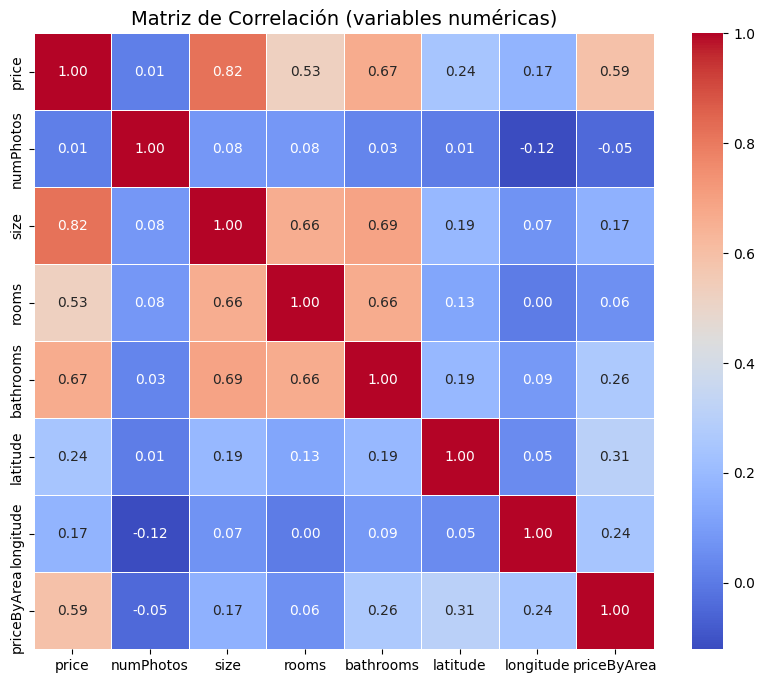

Correlación de cada variable con 'price':

price          1.000000
size           0.819999
bathrooms      0.666530
priceByArea    0.590509
rooms          0.526684
latitude       0.244338
longitude      0.172959
numPhotos      0.011260
Name: price, dtype: float64


In [56]:
# Matriz de correlación SOLO con las columnas numéricas
columnas_numericas = df3.select_dtypes(include=['float64', 'int64']).columns

# Crear matriz de correlación solo con las columnas numéricas
matriz_corr = df3[columnas_numericas].corr()

# Ordenar las columnas en función de su correlación con 'price'
matriz_corr_target = matriz_corr['price'].sort_values(ascending=False)

# Visualizar como un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación (variables numéricas)', fontsize=14)
plt.show()

# Mostrar correlación específica de las variables con el target 'price'
print("Correlación de cada variable con 'price':\n")
print(matriz_corr_target)


#### Conversiones numéricas básicas

#### Conversión numérica mediante mapeo de 'floor'


In [57]:
# Celda para encontrar detalle del significado de 'st' en 'floor' en la columna descripción
# Ajustar pandas para que no trunque el texto
pd.set_option('display.max_colwidth', None)

# Filtrar las filas donde 'floor' es igual a 'st'
df3[df3['floor'] == 'st'][['floor', 'description']]


,floor,description
ID,,
105501758,st,"PISO CON UNA REFORMA DE LUJO EN JUSTICIA Con una reforma de lujo este semisótano situado en un edificio de 1910 cuenta con 3 ventanales a la calle. Tiene 94 m2 contando con comunes según catastro, de los que 81 son de viviendas. Se distribuye en dos amplias habitaciones dobles ambas con cuarto de baño en suite. El salón-comedor incluye la cocina integrada en el mismo. Toda la casa cuenta con una excelente reforma, con ladrillo visto y una acertada utilización de la madera y materiales que hace de éste espacio un lugar perfecto tanto para residir como para alquilar. ¿Te imaginas vivir aqui? Contacte con nosotros para ver más inmuebles similares."
107058286,st,"TU PISO INMOBILIARIA vende en exclusiva, hermosa vivienda de una habitación, salón amplio, Cocina americana, baño con plato de ducha y patio. Vivienda con muy buena luminosidad. El apartamento cuenta con calefacción Individual y aire acondicionado. Cocina Americana totalmente equipada cuenta con todos los electrodomésticos. Amplio salón con acceso a un patio de uso y disfrute solo para esta vivienda. Ideal para inversores por la rentabilidad que genera actualmente, es un sótano que esta escriturado como local y por ley no se podría cambiar a vivienda. La vivienda se encuentra ubicada en el famoso barrio de Embajadores con más de 500 años de historia. La zona se encuentra en pleno auge gracias a su diversidad multicultural y su apreciada oferta de eventos culturales por la apertura de galerías de arte y teatros. Ofrece un ambiente bohemio y la población más cosmopolita de la capital. Es una zona que cuenta con restaurantes y bares de diferentes nacionalidades. Zona ideal para disfrutar de toda la oferta cultural y artística del centro de Madrid sin necesidad de transporte, pero al mismo tiempo a unos pasos del metro Tirso de Molina y Atocha, numerosas paradas de autobús."
107058336,st,"¡IDEAL PARA INVERSION! TU PISO INMOBILIARIA vende en exclusiva, hermosa vivienda de una habitación, salón amplio, Cocina americana, baño con plato de ducha y patio. Vivienda con muy buena luminosidad. El apartamento cuenta con calefacción Individual y aire acondicionado. Cocina Americana totalmente equipada cuenta con todos los electrodomésticos. Amplio salón con acceso a un patio de uso y disfrute solo para esta vivienda. Ideal para inversores por la rentabilidad que genera actualmente, es un sótano que esta escriturado como local y por ley no se podría cambiar a vivienda. La vivienda se encuentra ubicada en el famoso barrio de Embajadores con más de 500 años de historia. La zona se encuentra en pleno auge gracias a su diversidad multicultural y su apreciada oferta de eventos culturales por la apertura de galerías de arte y teatros. Ofrece un ambiente bohemio y la población más cosmopolita de la capital. Es una zona que cuenta con restaurantes y bares de diferentes nacionalidades. Zona ideal para disfrutar de toda la oferta cultural y artística del centro de Madrid sin necesidad de transporte, pero al mismo tiempo a unos pasos del metro Tirso de Molina y Atocha, numerosas paradas de autobús."
107058302,st,"TU PISO INMOBILIARIA vende en exclusiva, hermosa vivienda de una habitación, salón amplio, Cocina americana, baño con plato de ducha y patio. Vivienda con muy buena luminosidad. El apartamento cuenta con calefacción Individual y aire acondicionado. Cocina Americana totalmente equipada cuenta con todos los electrodomésticos. Amplio salón con acceso a un patio de uso y disfrute solo para esta vivienda. Ideal para inversores por la rentabilidad que genera actualmente, es un sótano que esta escriturado como local y por ley no se podría cambiar a vivienda. La vivienda se encuentra ubicada en el famoso barrio de Embajadores con más de 500 años de historia. La zona se encuentra en pleno auge gracias a su diversidad multicultural y su apreciada oferta de eventos culturales por la apertura de galerías de arte y teatros. Ofrece un ambiente bohemio y la població

In [59]:
def convertir_floor(dataframe):
    """
    Convierte los valores de la columna 'floor' a numéricos según un mapeo predefinido.
    - Los valores que ya son numéricos no se modifican.
    - Si los valores no son numéricos, se convierte el texto a minúsculas y se aplica un diccionario de mapeo.
    - Si un valor no está en el diccionario, se asigna 0 por defecto.
    - Si el valor sigue siendo texto, se convierte a NaN.
    
    :param dataframe: DataFrame que debe contener una columna 'floor'.
    :return: DataFrame con la columna 'floor' convertida a valores numéricos.
    """
    # Diccionario de mapeo
    floor_mapping = {
        'entreplanta': 0.5, 'ent': 0.5, 'en': 0.5,
        'baja': 0, 'bajo': 0, 'bj': 0, 'street': 0, 'st': 0,
        'semisótano': -0.5, 'semisotano': -0.5, 'ss': -0.5,
        'sótano': -1, 'sotano': -1, 'sot': -1
    }
    
    # Función para convertir los valores de 'floor'
    def map_floor(value):
        # Si el valor es numérico, no lo modificamos
        if isinstance(value, (int, float)):
            return value
        
        # Convertir a string y a minúsculas
        value = str(value).lower()
        
        # Retornar el valor mapeado o 0 si no está en el diccionario
        return floor_mapping.get(value, None)
    
    # Aplicar la función a la columna 'floor' para mapeo
    dataframe['floor'] = dataframe['floor'].apply(map_floor)
    
    # Si después de aplicar el mapeo aún hay valores no numéricos, convertirlos a NaN
    dataframe['floor'] = pd.to_numeric(dataframe['floor'], errors='coerce')
    
    return dataframe


In [60]:
df3_num = convertir_floor(df3)
df3_num.head(60)

,price,numPhotos,floor,propertyType,size,exterior,rooms,bathrooms,address,neighborhood,...,hasVideo,status,hasLift,priceByArea,hasPlan,has3DTour,has360,topPlus,suggestedTexts_subtitle,suggestedTexts_title
ID,,,,,,,,,,,,,,,,,,,,,
107526421,1095000.0,43,NaN,flat,146.0,True,3,2,calle de las Fuentes,Sol,...,True,good,True,7500.0,True,True,False,True,"Sol, Madrid",Piso en calle de las Fuentes
107246640,1195000.0,27,NaN,flat,134.0,True,3,3,calle del Divino Pastor,Malasaña-Universidad,...,True,good,True,8918.0,True,True,True,True,"Malasaña-Universidad, Madrid",Piso en calle del Divino Pastor
106773918,790000.0,33,NaN,flat,148.0,True,2,2,Barrio Lavapiés-Embajadores,Lavapiés-Embajadores,...,True,good,True,5338.0,True,True,False,True,"Lavapiés-Embajadores, Madrid",Piso
102711209,2350000.0,44,NaN,flat,218.0,True,4,4,Carrera de San Jerónimo,Sol,...,True,good,True,10780.0,True,True,False,True,"Sol, Madrid",Piso en Carrera de San Jerónimo
106822977,235000.0,34,0.0,studio,38.0,False,0,1,calle de San Andrés,Malasaña-Universidad,...,True,good,True,6184.0,True,True,False,True,"Malasaña-Universidad, Madrid",Estudio en calle de San Andrés
105113334,1030000.0,42,NaN,penthouse,67.0,True,2,1,calle de Fuencarral,Malasaña-Universidad,...,True,good,True,15373.0,True,True,False,True,"Malasaña-Universidad, Madrid",Ático en calle de Fuencarral
106848960,1200000.0,30,NaN,flat,132.0,True,2,2,calle de Fuencarral,Malasaña-Universidad,...,True,good,True,9091.0,True,True,False,True,"Malasaña-Universidad, Madrid",Piso en calle de Fuencarral
106500063,1195000.0,32,NaN,flat,134.0,True,3,3,calle del Divino Pastor,Malasaña-Universidad,...,True,good,True,8918.0,True,True,False,True,"Malasaña-Universidad, Madrid",Piso en calle del Divino Pastor
106151385,1490000.0,30,NaN,duplex,216.0,True,2,3,calle de Santiago,Palacio,...,True,good,True,6898.0,True,True,False,True,"Palacio, Madrid",Dúplex en calle de Santiago


#### Conversión numérica mediante mapeo de 'status'

#### Conversión automática resto de columnas binarias y (algunas) categóricas 

In [ ]:
def convertir_a_numerico (dataframe):
    """
    Convierte los valores del DataFrame:
    - Convierte columnas booleanas a 0 y 1.
    - Renombra 'district' → 'distrito' y 'neighborhood' → 'barrio'.
    - Usa one-hot encoding para 'district' y 'neighborhood', si existen en el DataFrame.

    :param dataframe: DataFrame de entrada.
    :return: DataFrame transformado.
    """
    df_numerico = dataframe.copy()

    # Convertir booleanos a 0 y 1
    bool_cols = ['exterior', 'hasVideo', 'hasLift', 'hasPlan', 'has3DTour', 'has360', 'topPlus']
    for col in bool_cols:
        if col in df_numerico.columns:
            df_numerico[col] = df_numerico[col].astype(int)
            
    # Renombrar columnas antes de cualquier otra transformación
    df_numerico = df_numerico.rename(columns={'district': 'distrito', 'neighborhood': 'barrio'})

    # Aplicar one-hot encoding a 'district' y 'neighborhood' si existen
    for col in ['districto', 'barrio']:
        if col in df_numerico.columns:
            dummies = pd.get_dummies(df_numerico[col], prefix=col, dtype=int)
            df_numerico = pd.concat([df_numerico.drop(columns=[col]), dummies], axis=1)

    return df_numerico


In [ ]:
# Aplicar la conversión
df3_num = convertir_a_numerico(df3)
df3_num.head()

In [ ]:
numericas (df3_num)

###
Seguimos con la reducción de variables

In [ ]:
# Borra las columnas con una correlacion menor a 0.2
corr = np.abs(df3.corr()['price']).sort_values(ascending=True)
print(corr)

bad_corr_feat = corr[corr <0.2].index.values
print(bad_corr_feat)

df3.drop(columns = bad_corr_feat, inplace = True)

In [ ]:
# Matriz de correlación con variables categóricas
# from scipy.stats import chi2_contingency

# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x, y)
#     chi2 = chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2 / n
#     r, k = confusion_matrix.shape
#     return np.sqrt(phi2 / min(k-1, r-1))

# corr_matrix = pd.DataFrame(index=df3.columns, columns=df3.columns)

# for col1 in df3.columns:
#     for col2 in df3.columns:
#         if col1 != col2:
#             corr_matrix.loc[col1, col2] = cramers_v(df3[col1], df3[col2])
#         else:
#             corr_matrix.loc[col1, col2] = 1  # Autocorrelación

# corr_matrix = corr_matrix.astype(float)

# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Matriz de Asociación (Cramér's V)")
# plt.show()

## 6. Análisis univariante

## 15. División en train y test
(resevar una porción de los datos obtenidos para probar nuestros modelos)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1),
                                                    df['price'],
                                                    test_size=0.2,
                                                    random_state=42)

___________________________________________
## XX. Transformaciones a aplicar a test (nuevos datos que vengan)

In [ ]:
#agrupación del código a aplicar a test, que apliqué en train

# Detener la ejecución de esta celda

# Todo lo que esté aquí no se ejecutará
print("Esta celda está reservada para aplicar a los datos de test.")
return

# # Definir la columna target
target = 'price'  # Reemplaza con el nombre real de la columna target

# Verificar si la columna target está en el DataFrame y eliminarla si existe
if target in datos_test.columns:
    datos_test = datos_test.drop(columns=[target])

# Continuar con el resto del código sin interrupciones
# df.drop_duplicates(keep='first', inplace=True)    #no es necesario eliminar duplicados en el test



df = datos_test.reset_index(drop=True).set_index("propertyCode")
df.index.name = 'ID'

col_eliminar = ['thumbnail','externalReference', 'priceInfo', 'operation', 'province', 'municipality',
       'country', 'showAddress', 'url', 'newDevelopment', 'change', 'highlight', 'savedAd', 
       'notes','hasStaging', 'topNewDevelopment', 'parkingSpace' ,'newDevelopmentFinished' ]
df.drop(col_eliminar, axis=1, inplace=True)

df = expand_dict_columns(df)

imputar_ascensor(df)